## Fracture Liason Services Web Scraper

This is the script to scrape the Fracture Liasons Services data from the online database at: [https://www.fffap.org.uk](https://www.fffap.org.uk/80257FC4002BDD96).
Specifically, the DXA within 12 weeks and Investigations and Treatement data.

# [Step 1]:
Press the 'Run all' button on the toolbard at the top of the current page.

Screenshot 2026-02-05 115742.png


 Or the play button that appears when you hover over the leftmost corner of the cell below.

 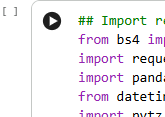

In [ ]:
## Import relevant libraries:
from bs4 import BeautifulSoup
import requests, certifi
import pandas as pd
from datetime import datetime
import pytz
import os
import re
from requests.adapters import HTTPAdapter
from urllib3.util import Retry

# Suppress only the single InsecureRequestWarning from urllib3 needed. REMOVE IF NECESSARY
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

def replaceValsWithNationalVals(variable_dict=None, localValsVar=None, nationalValsVar=None):
    if any(nationalValsVar in d for d in variable_dict) and not any(localValsVar in d for d in variable_dict):
                mnths_dict = next(d for d in variable_dict if nationalValsVar in d)
                variable_dict.append({localValsVar: mnths_dict[nationalValsVar]})

# setup working directory
base_path = '/content/'
print('*******')

siteList = ['[All]','7A2T','7A5T','GWY','LLD','MOR','NEV']
siteHBDict = {
    '7A2T': 'Hywel Dda UHB',
    '7A5T': 'CTM UHB',
    'GWY': 'Ysbyty Gwynedd Hospital',
    'LLD': 'University Hospital Llandough',
    'MOR': 'Morriston Hospital ABMHU',
    'NEV': 'Aneurin Bevan University Health Board',
    '[All]': 'National Averages'
}
ChartList = ['DXAwithin12weeks','Investigationandtreatment']
DXA_df = pd.DataFrame()
Investigationandtreatment_df = pd.DataFrame()

retry_strategy = Retry(
    total=4,  # Maximum number of retries
    status_forcelist=[429, ## Too Many Requests
                      500, ## Internal Server Error
                      502, ## 502 Bad Gateway
                      503, ## 503 Service Unavailable
                      504 ## 504 Gateway Timeout
                      ],  # HTTP status codes to retry on
)
# Create an HTTP adapter with the retry strategy and mount it to session
adapter = HTTPAdapter(max_retries=retry_strategy)

date_of_scrape = datetime.now(pytz.timezone("Europe/London"))
date_of_scrape = date_of_scrape.strftime("%Y-%m-%d %H:%M:%S")

# Create a new session object
session = requests.Session()
session.mount('https://', adapter)

# Loop through each Site and Chart to scrape data
for chart in ChartList:
    for site in siteList:
        url = f'https://www.fffap.org.uk/FLS/charts.nsf/vwPcharts/{chart}?opendocument&org={site}'

        print(url)

        result = session.get(
            url,
            headers={'User-Agent': 'Mozilla/5.0'},
            verify=False
        )

        ## Parse Content of Results Object
        doc = BeautifulSoup(result.text, "html.parser")

        #LOG
        print("- Looking for numerical data")
        # Find the Numeric data in the html code
        data = '\n'.join(script.text for script in doc.find_all('script', {'type': 'text/javascript'}))
        match_scripts = re.findall(r"(.*)( = )([^;]*)", data)
        #LOG
        print(f"- Numerical data found")

        #LOG
        print(f"- Processing data for FLS Service: {siteHBDict[site]}")
        # Convert List of Tuples to List of Dictionaries
        variable_dict = []
        """
        The 3 part Tuple for each list item will always match the below Index positions:
        0 = Javascript variable name (i.e. var cat)
        1 = will always be the string '='
        2 = the content of the variable.
        """
        count = 0

        # Differentiate between [All] sites and individual sites
        if site != '[All]':
            for variable in match_scripts:
                if match_scripts[count][0] in [
                                            "var cats",
                                            "var dxah" ,
                                            "var bp",
                                            "var months",
                                            "var mnths",
                                            "var dxan",
                                            "var bpn",
                                            "var axa",
                                            "var falls",
                                            "var dxa75",
                                            "var axan",
                                            "var fallsn",
                                            "var dxa75n"
                                            ]:
                    variable_dict.append({variable[0].strip(): variable[2].replace("[", "").replace("]", "").replace("'", "").strip().split(",")})
                    count += 1
                else:
                    count += 1
                    pass
        else:
            # For [All] sites, local variables are not available, only national equivalents
            for variable in match_scripts:
                # Only capture national variables
                if match_scripts[count][0] in [
                                            "var mnths",
                                            "var dxan",
                                            "var bpn",
                                            "var axan",
                                            "var fallsn",
                                            "var dxa75n"
                                            ]:
                    variable_dict.append({variable[0].strip(): variable[2].replace("[", "").replace("]", "").replace("'", "").strip().split(",")})
                    count += 1
                else:
                    count += 1
                    pass
            #LOG
            print("- Tuples converted to dictionaries")

            # Fill missing local variables with national equivalents

            #LOG
            print(f"- Replacing missing local variables with national equivalents")
            replaceValsWithNationalVals(variable_dict, 'var cats', 'var mnths')
            replaceValsWithNationalVals(variable_dict, 'var dxah', 'var dxan')
            replaceValsWithNationalVals(variable_dict, 'var bp', 'var bpn')
            replaceValsWithNationalVals(variable_dict, 'var axa', 'var axan')
            replaceValsWithNationalVals(variable_dict, 'var falls', 'var fallsn')
            replaceValsWithNationalVals(variable_dict, 'var dxa75', 'var dxa75n')
            #LOG
            print(f"- Finished replacing missing local variables with national equivalents")

        # Convert List of Dictionaries to DataFrame
        temp_df = pd.DataFrame()
        #LOG
        print(f"- Converting list of dictionaries to DataFrame for FLS Service: {siteHBDict[site]}")
        for var_idx in range(len(variable_dict)):
            key = list(variable_dict[var_idx].keys())[0]
            ser = pd.Series(variable_dict[var_idx][key])
            try:
                temp_df.insert(var_idx, key, ser)
            except ValueError:
                temp_df.insert(var_idx, key + str(var_idx), ser)
        #LOG
        print(f"- Temporary DataFrame created for FLS Service: {siteHBDict[site]}")

        # Rename Columns
        temp_df.rename(columns={
            "var cats": "Date Index Fracture Diagnosed Year & Month (Alt)",
            "var dxah": "Patients where a DXA was ordered or recommended and was completed within 12 weeks %" ,
            "var bp": "Patients offered Bone Protection medication %",
            "var months": "Date Index Fracture Diagnosed Year & Month",
            "var mnths": "Date Index Fracture Diagnosed Year & Month",
            "var dxan": "Patients where a DXA was ordered or recommended and was completed within 12 weeks National %",
            "var bpn":"Bone Protection Meds National %",
            "var axa": "FLS assessment <=90 days %",
            "var falls": "Patients offered or referred for falls risk assessment %",
            "var dxa75": "Patients<75 offered or undergone a DXA %",
            "var axan": "FLS assessment <=90 days National %",
            "var fallsn": "Falls assessment National %",
            "var dxa75n":"Patients<75 offered or undergone a DXA National %"
        }, inplace=True)
        #LOG
        print(f"- Columns renamed (in temporary dataframe) for FLS Service: {siteHBDict[site]}")

        # Add Unit Code and FLS Service columns
        temp_df["Unit Code"] = f"{site}"
        temp_df["FLS Service"] = siteHBDict[site]
        ## Add Date of Scrape column
        temp_df["Date extracted"] = date_of_scrape
        #LOG
        print(f"- Unit Code, FLS Service and Date extracted data (for FLS Service: {siteHBDict[site]}) updated in temporary dataframe")

        # Append to relevant DataFrame
        if chart == 'DXAwithin12weeks':
            DXA_df = pd.concat([DXA_df, temp_df], ignore_index=True)
            #LOG
            print(f"- DXA dataframe updated with values (for FLS Service: {siteHBDict[site]}) from the temporary dataframe")
        elif chart == 'Investigationandtreatment':
            Investigationandtreatment_df = pd.concat([Investigationandtreatment_df, temp_df], ignore_index=True)
            #LOG
            print(f"- Investigation and treatment dataframe values (for FLS Service: {siteHBDict[site]}) from the temporary dataframe")
        #LOG
        print(f"- {chart} data extracted for FLS Service: {siteHBDict[site]}")
        print("---------------------------------------------------")

# Replace blank spaces with NaN in both dataframes
DXA_df = DXA_df.replace(r'^\s*$', pd.NA, regex=True)
Investigationandtreatment_df = Investigationandtreatment_df.replace(r'^\s*$', pd.NA, regex=True)

#Reorder Columns for both dataframes
Investigationandtreatment_df = Investigationandtreatment_df[[
    "Date extracted",
    "FLS Service",
    "Unit Code",
    "Date Index Fracture Diagnosed Year & Month",
    "FLS assessment <=90 days %",
    "FLS assessment <=90 days National %",
    "Patients offered or referred for falls risk assessment %",
    "Falls assessment National %",
    "Patients offered Bone Protection medication %",
    "Bone Protection Meds National %",
    "Patients<75 offered or undergone a DXA %",
    "Patients<75 offered or undergone a DXA National %",

]]
DXA_df = DXA_df[[
    "Date extracted",
    "FLS Service",
    "Unit Code",
    "Date Index Fracture Diagnosed Year & Month",
    "Patients where a DXA was ordered or recommended and was completed within 12 weeks %",
    "Patients where a DXA was ordered or recommended and was completed within 12 weeks National %"

]]
#LOG
print("Columns reordered for both DataFrames")

#Directory and file path
directory_path = f'FLS_Scrape_{date_of_scrape}'
os.makedirs(directory_path, exist_ok=True)

dxa_filename = f"FLS_DXA_within_12_weeks_{date_of_scrape}".replace(" ","__").replace(":","_")
IandT_filename = f"FLS_investigation_and_treatment_{date_of_scrape}".replace(" ","__").replace(":","_")
dxa_file_path = os.path.join(directory_path, f'{dxa_filename}.csv')
IandT_file_path = os.path.join(directory_path, f'{IandT_filename}.csv')

# Export DataFrames to CSV
DXA_df.to_csv(dxa_file_path, encoding='utf-8', index=False)
Investigationandtreatment_df.to_csv(IandT_file_path, encoding='utf-8', index=False)


*******
https://www.fffap.org.uk/FLS/charts.nsf/vwPcharts/DXAwithin12weeks?opendocument&org=[All]
- Looking for numerical data
- Numerical data found
- Processing data for FLS Service: National Averages
- Tuples converted to dictionaries
- Replacing missing local variables with national equivalents
- Finished replacing missing local variables with national equivalents
- Converting list of dictionaries to DataFrame for FLS Service: National Averages
- Temporary DataFrame created for FLS Service: National Averages
- Columns renamed (in temporary dataframe) for FLS Service: National Averages
- Unit Code, FLS Service and Date extracted data (for FLS Service: National Averages) updated in temporary dataframe
- DXA dataframe updated with values (for FLS Service: National Averages) from the temporary dataframe
- DXAwithin12weeks data extracted for FLS Service: National Averages
---------------------------------------------------
https://www.fffap.org.uk/FLS/charts.nsf/vwPcharts/DXAwithin12wee

# [Step 2]:

Once the code has run (as part of the first step), then go to the side bar and find the folder icon.


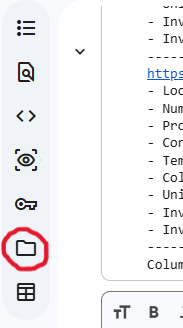


Once you've found it, click on it to open all the folders in the directory.
And open the 'content' folder.
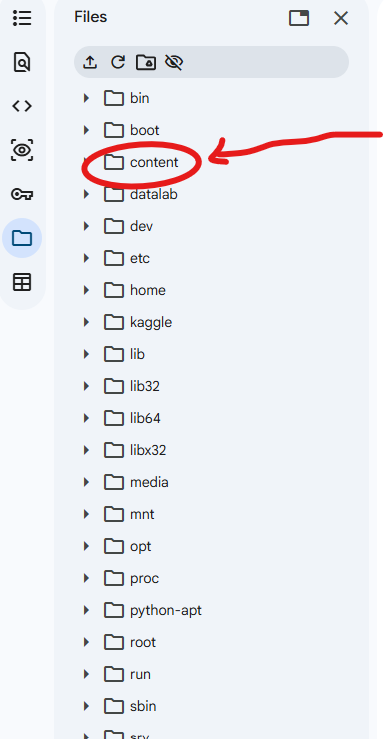


# [Step 3]:

Once in the 'content' folder. You'll find a folder with the name 'FLS_Scrape_{Date and Time of Scrape}'. Find the folder with the most recent scrape, or your desired scrape time. then click the dropdown button to view its contents.


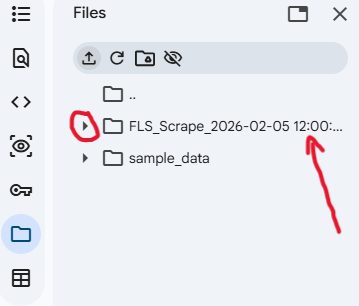


In there you will find two files, both csvs, one for DXA within 12 weeks, and one for Investigation cand treatment. Click the three dots on the rightmost end of the file name, and then hit download.

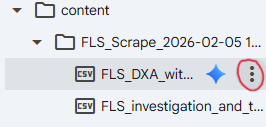
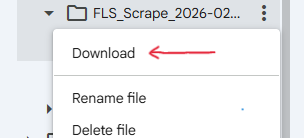